<h1>Setting up the environment and the dataset<h1>

In [1]:
# Importing necessary libraries
import tensorflow as tf
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from keras import layers
from keras import Model
from keras import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt
from sklearn.metrics import zero_one_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold

In [2]:
# Setting up the path to locate the dataset
PATH = '/Users/matteocastagna/Documents/Università/Magistrale/1_semestre_2/statistical method for machine learning/progetto/dataset'
data_dir = pathlib.Path(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Number of images in the dataset: {image_count}')

Number of images in the dataset: 5182


In [4]:
# Setting up dimensions of the images that will be fed to the network and number epochs for training (anf hyperparameter
# tuning ) and fine tuning
IMG_HEIGHT = 120
IMG_WIDTH = 120
TUNING_EPOCHS = 5
TOTAL_EPOCHS = 2 * TUNING_EPOCHS # number of epochs used for training
RANDOM_SEED = 100

# Creating the dataset as a tf.data.Dataset. Even if later the training set etc. will be converted to numpy array, loading the dataset
# this way and then converting is still faster than using os to load all the images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  color_mode = 'rgb',
  shuffle = False,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = None # The batch size is set to None so it can be tuned later
)

Found 5182 files belonging to 2 classes.


In [5]:
# Printing dataset classes
class_names = ds.class_names
print(f'First class: {class_names[0]}')
print(f'Second class: {class_names[1]}')

First class: chihuahua
Second class: muffin


In [6]:
# Shuffling the dataset
ds = ds.shuffle(buffer_size = ds.cardinality(), reshuffle_each_iteration = False, seed = RANDOM_SEED)

# Splitting the dataset into train and validation set
train_ds, val_ds = tf.keras.utils.split_dataset(ds, left_size = 0.8, shuffle = False)

# Printing the cardinality of train and validation set
train_card = tf.data.experimental.cardinality(train_ds)
print(f'Training set cardinality: {train_card.numpy()}')
val_card = tf.data.experimental.cardinality(val_ds)
print(f'Validation set cardinality: {val_card.numpy()}')

Training set cardinality: 4146
Validation set cardinality: 1036


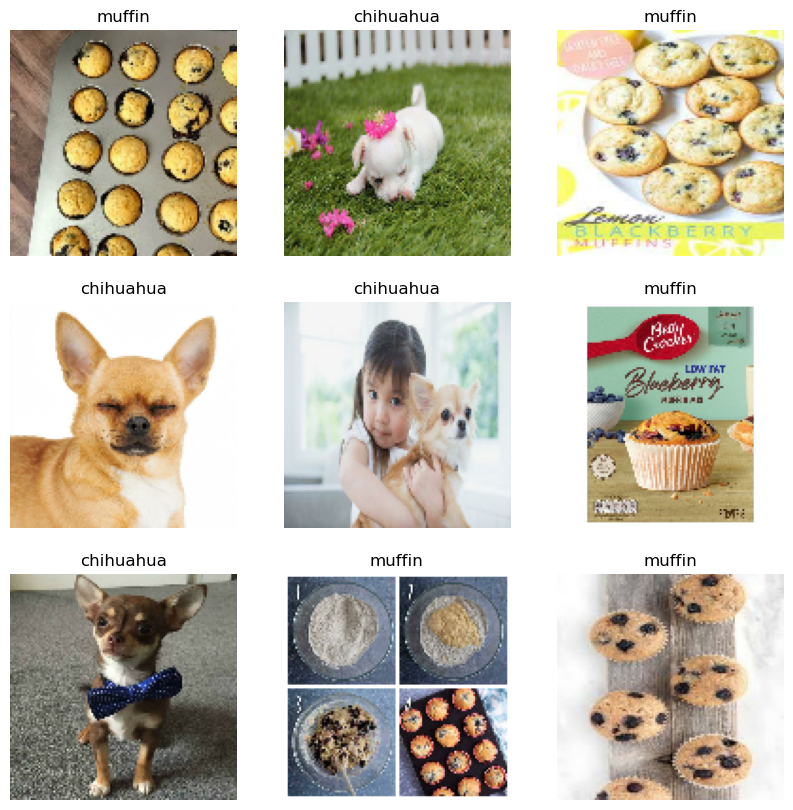

In [7]:
# Showing the first 9 images from the training set
plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_ds.take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images.numpy().astype("uint8"))
    plt.title(class_names[labels])
    plt.axis("off")
    i = i + 1

<h1>Setting up the network and performing hyperparameters tuning<h1>

In [8]:
# Keras-tuner HyperModel class let encapsulate a model for sharing and reuse, an hypermodel can be passed to a keras tuner to perform
# keras automatic hyperparameters tuning
class MyHypermodel(kt.HyperModel):
    
    def build(self, hp):
        
        input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
        inputs = Input(shape = input_shape)
        
        # Rescaling layer
        x = layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))(inputs)
        
        hp_pooling = hp.Choice('pooling', ['max', 'avg'])
        for i in range(hp.Choice('conv_layers', values = [1, 3, 5])):    
            x = layers.Conv2D(
                    filters = hp.Choice('fil_' + str(i + 1), values = [16, 32, 64]),
                    kernel_size = hp.Choice('ks_' + str(i + 1), values = [3, 5]),
                    activation = None,
                    padding = "same",
                )(x)

            x = layers.BatchNormalization()(x)
            x = layers.ReLU()(x)
            
            if hp_pooling == "max":
                x = layers.MaxPooling2D()(x)
            else:
                x = layers.AveragePooling2D()(x)
        
        # Fully connected classification head
        x = layers.Flatten()(x)
        x = layers.Dense(16)(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(1)(x)
        x = layers.Activation('sigmoid')(x)
        
        model = Model(inputs, x)
              
        model.compile(
            # Tuning the learning rate for the optimizer, choosing an optimal value from 0.1, 0.01 or 0.001
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3])),
            loss = tf.keras.losses.BinaryCrossentropy(),
            metrics = ['accuracy']
        )
        
        return model
    
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tuning the batch size, choosing an optimal value from 16, 32 or 48
            batch_size = hp.Int("batch_size", 16, 48, step = 16),
            **kwargs,
        )

# As when loading the dataset previously the batch size was setted to None, the dataset is made of single examples (height x width x channel),
# but functions such as tuner.search(*), fit(*), etc. expect as input something like (batch_size x height x width x channel);
# therefore I convert training and validation set from tensorflow dataset to numpy array and split samples from labels,
# then feed the model with them instead of the tensorflow dataset
X_train = np.asarray(list(train_ds.map(lambda x, y: x)))
Y_train = np.asarray(list(train_ds.map(lambda x, y: y)))

X_val= np.asarray(list(val_ds.map(lambda x, y: x)))
Y_val = np.asarray(list(val_ds.map(lambda x, y: y)))

del train_ds, val_ds

# Exploring randomly the parameter space
tuner = kt.RandomSearch(
    MyHypermodel(),
    objective = 'val_accuracy',
    directory = 'custom/best_hyperparameters',
    project_name = 'tuning',
    overwrite = True,
    seed = RANDOM_SEED,
    max_trials = 30
)

# Early stopping for the hyperparameter tuning
stop_early = EarlyStopping(monitor='val_loss', patience = 3, verbose = 1)

tuner.search(X_train, Y_train,
             epochs = TUNING_EPOCHS,
             callbacks = [stop_early],
             validation_data = (X_val, Y_val),
             shuffle = False,
)

# Printing best hyperparameters
print("", end="\n")
print(f'Best learning rate: {tuner.get_best_hyperparameters()[0]["learning_rate"]}')
print(f'Best batch size: {tuner.get_best_hyperparameters()[0]["batch_size"]}')
print(f'Number of filters: {tuner.get_best_hyperparameters()[0]["conv_layers"]}')
if tuner.get_best_hyperparameters()[0]["conv_layers"] == 1:
    print(f'First layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_1"]}'); print(f'First layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_1"]}')
elif tuner.get_best_hyperparameters()[0]["conv_layers"] == 3:
    print(f'First layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_1"]}'); print(f'First layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_1"]}')
    print(f'Second layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_2"]}'); print(f'Second layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_2"]}')
    print(f'Third layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_3"]}'); print(f'Third layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_3"]}')
elif tuner.get_best_hyperparameters()[0]["conv_layers"] == 5:
    print(f'First layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_1"]}'); print(f'First layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_1"]}')
    print(f'Second layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_2"]}'); print(f'Second layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_2"]}')
    print(f'Third layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_3"]}'); print(f'Third layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_3"]}')
    print(f'Fourth layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_4"]}'); print(f'Fourth layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_4"]}')
    print(f'Fifth layer n. of filters: {tuner.get_best_hyperparameters()[0]["fil_5"]}'); print(f'Fifth layer filters kernel size: {tuner.get_best_hyperparameters()[0]["ks_5"]}')
print(f'Pooling technique: {tuner.get_best_hyperparameters()[0]["pooling"]}pooling')

Trial 30 Complete [00h 00m 34s]
val_accuracy: 0.61583012342453

Best val_accuracy So Far: 0.8812741041183472
Total elapsed time: 00h 12m 45s
INFO:tensorflow:Oracle triggered exit

Best learning rate: 0.001
Best batch size: 16
Number of filters: 3
First layer n. of filters: 16
First layer filters kernel size: 5
Second layer n. of filters: 16
Second layer filters kernel size: 3
Third layer n. of filters: 16
Third layer filters kernel size: 3
Pooling technique: maxpooling


In [9]:
# Plotting the performances of the models generated by the various combinations of hyperparameters
# Plotting both the parallel plot and the dataframe with the hyperparameters anc validation accuracy score for a more
# comprehensive visualization
import plotly.express as px
import pandas as pd

l_trial = []
l_lr = []
l_bs = []
l_conv = []
l_fil_1 = []
l_fil_2 = []
l_fil_3 = []
l_fil_4 = []
l_fil_5 = []
l_ks_1 = []
l_ks_2 = []
l_ks_3 = []
l_ks_4 = []
l_ks_5 = []
l_pool = []
l_score = []
for trial in tuner.oracle.trials.values():
    l_trial.append(int(trial.trial_id) + 1)
    l_lr.append(trial.hyperparameters["learning_rate"])
    l_bs.append(trial.hyperparameters["batch_size"])
    l_conv.append(trial.hyperparameters["conv_layers"])
    
    if trial.hyperparameters["conv_layers"] == 1:
        l_fil_1.append(trial.hyperparameters["fil_1"])
        l_fil_2.append(None); l_fil_3.append(None); l_fil_4.append(None); l_fil_5.append(None)
        l_ks_1.append(trial.hyperparameters["ks_1"])
        l_ks_2.append(None); l_ks_3.append(None); l_ks_4.append(None); l_ks_5.append(None)
    elif trial.hyperparameters["conv_layers"] == 3:
        l_fil_1.append(trial.hyperparameters["fil_1"]); l_fil_2.append(trial.hyperparameters["fil_2"])
        l_fil_3.append(trial.hyperparameters["fil_3"]); l_fil_4.append(None); l_fil_5.append(None)
        l_ks_1.append(trial.hyperparameters["ks_1"]); l_ks_2.append(trial.hyperparameters["ks_2"])
        l_ks_3.append(trial.hyperparameters["ks_3"]); l_ks_4.append(None); l_ks_5.append(None)
    elif trial.hyperparameters["conv_layers"] == 5:
        l_fil_1.append(trial.hyperparameters["fil_1"]); l_fil_2.append(trial.hyperparameters["fil_2"])
        l_fil_3.append(trial.hyperparameters["fil_3"]); l_fil_4.append(trial.hyperparameters["fil_4"])
        l_fil_5.append(trial.hyperparameters["fil_4"])
        l_ks_1.append(trial.hyperparameters["ks_1"]); l_ks_2.append(trial.hyperparameters["ks_2"])
        l_ks_3.append(trial.hyperparameters["ks_3"]); l_ks_4.append(trial.hyperparameters["ks_4"])
        l_ks_5.append(trial.hyperparameters["ks_5"])
    
    
    l_pool.append(trial.hyperparameters["pooling"])
    l_score.append(trial.score)
    
df = pd.DataFrame(list(zip(l_trial, l_lr, l_bs, l_conv, l_fil_1, l_fil_2, l_fil_3,
                           l_fil_4, l_fil_5, l_ks_1, l_ks_2, l_ks_3, l_ks_4, l_ks_5, l_pool, l_score)),
               columns =['Trial #', 'Learning rate', 'Batch size', 'Conv layers #', 'Fil1 #', 'Fil2 #', 'Fil3 #', 'Fil4 #', 'Fil5 #',
                         'KS 1', 'KS 2', 'KS 3', 'KS 4', 'KS 5', 'Pooling func', 'Validation accuracy'])

# parallel_categories instead of parallel_coordinates helps visualize better the result of the tuning in terms of tracing the
# hyperparameters of each trial. The lighter (yellow) is the color the better the score of the corresponding trial is, the
# darker (blue) is the color the worst the score of the corresponding trial is
fig = px.parallel_categories(df, color="Validation accuracy", labels={'Trial #': 'Trial #', 'Learning rate' : 'Learning rate',
                                          'Batch size' : 'BS', 'Conv layers #' : 'Conv Lays #',
                                          'Fil1 #' : 'Fil1 #', 'Fil2 #' : 'Fil2 #', 'Fil3 #' : 'Fil3 #', 'Fil4 #' : 'Fil4 #', 'Fil5 #' : 'Fil5 #',
                                          'KS 1' : 'KS 1', 'KS 2' : 'KS 2', 'KS 3' : 'KS 3', 'KS 4' : 'KS 4', 'KS 5' : 'KS 5',
                                          'Pooling func': 'Pooling func', 'Validation accuracy' :  'Validation accuracy'})

fig.update(layout_coloraxis_showscale=False)
fig.show()

df

Trial #  Learning rate  Batch size  Conv layers #  Fil1 #  Fil2 #  Fil3 #  \
0         1          0.001          16              3      16    16.0    16.0   
1         2          0.100          16              5      16    64.0    32.0   
2         3          0.001          48              5      16    32.0    32.0   
3         4          0.010          16              3      16    32.0    32.0   
4         5          0.010          48              3      64    32.0    64.0   
5         6          0.010          16              5      32    16.0    16.0   
6         7          0.010          16              3      16    16.0    64.0   
7         8          0.010          48              3      32    16.0    32.0   
8         9          0.100          16              1      16     NaN     NaN   
9        10          0.001          48              3      16    16.0    64.0   
10       11          0.001          48              5      32    16.0    32.0   
11       12          0.100          32              3      64    64.0    64.0   
12       13          0.100          32              3      16    16.0    16.0   
13       14          0.100          48              5      32    16.0    32.0   
14       15          0.010          48              1      32     NaN     NaN   
15       16          0.010          32              1      32     NaN     NaN   
16       17          0.010          32              3      32    16.0    64.0   
17       18          0.001          48              1      64     NaN     NaN   
18       19          0.100          48              3      32    32.0    32.0   
19       20          0.100          48              1      16     NaN     NaN   
20       21          0.100          48              5      64    16.0    16.0   
21       22          0.001          32              1      32     NaN     NaN   
22       23          0.100          16              1      16     NaN     NaN   
23       24          0.001          16              1      16     NaN     NaN   
24       25          0.100          32              3      32    16.0    16.0   
25       26          0.100          48              1      32     NaN     NaN   
26       27          0.001          16              3      16    64.0    16.0   
27       28          0.100          16              5      16    16.0    64.0   
28       29          0.010          16              3      64    32.0    16.0   
29       30          0.100          32              3      64    32.0    64.0   

    Fil4 #  Fil5 #  KS 1  KS 2  KS 3  KS 4  KS 5 Pooling func  \
0      NaN     NaN     5   3.0   3.0   NaN   NaN          max   
1     16.0    16.0     3   5.0   3.0   3.0   3.0          avg   
2     64.0    64.0     5   3.0   3.0   5.0   5.0          avg   
3      NaN     NaN     3   5.0   3.0   NaN   NaN          avg   
4      NaN     NaN     3   3.0   5.0   NaN   NaN          avg   
5     16.0    16.0     3   5.0   3.0   5.0   5.0          avg   
6      NaN     NaN     5   5.0   5.0   NaN   NaN          avg   
7      NaN     NaN     5   5.0   5.0   NaN   NaN          avg   
8      NaN     NaN     5   NaN   NaN   NaN   NaN          max   
9      NaN     NaN     5   5.0   3.0   NaN   NaN          max   
10    32.0    32.0     5   5.0   3.0   5.0   5.0          max   
11     NaN     NaN     5   3.0   3.0   NaN   NaN          avg   
12     NaN     NaN     5   3.0   5.0   NaN   NaN          max   
13    32.0    32.0     5   5.0   5.0   3.0   5.0          max   
14     NaN     NaN     3   NaN   NaN   NaN   NaN          avg   
15     NaN     NaN     5   NaN   NaN   NaN   NaN          avg   
16     NaN     NaN     3   3.0   3.0   NaN   NaN          avg   
17     NaN     NaN     5   NaN   NaN   NaN   NaN          avg   
18     NaN     NaN     3   5.0   3.0   NaN   NaN          max   
19     NaN     NaN     5   NaN   NaN   NaN   NaN          max   
20    16.0    16.0     3   3.0   3.0   3.0   5.0          max   
21     NaN     NaN     5   NaN   NaN   NaN   NaN          max 

<h1>5-Fold Cross Validation<h1>

In [10]:
# Setting up 5-fold cross validation
kfold = KFold(n_splits = 5, shuffle = False)

# Splitting samples from labels of the dataset
X = np.asarray(list(ds.map(lambda x, y: x)))
Y = np.asarray(list(ds.map(lambda x, y: y)))

del X_train, Y_train, X_val, Y_val

In [11]:
i = 0
model_history_train = [] # List to save train losses and accuracies of the models over each epoch
model_history_val = [] # List to save validation losses and accuracies of the models over each epoch
# Y_pred_list and Y_val_list are used later to plot the confusion matrix of the 5-fold cross validation models
Y_pred_list = [] # List to save each model prediction during validation
Y_val_list = [] # List to save validation set labels of each model
n_chihuahua_muffin = [] # List to save the number of chiahuahua and muffin examples per partition to look later if they were balanced

for train_index, test_index in kfold.split(X):
    
    ##############################################
    ################## Training ##################
    ##############################################
    
    print(f'Fold {i + 1}')
    
    X_train, X_val = X[train_index], X[test_index] # Building the training set
    Y_train, Y_val = Y[train_index], Y[test_index] # Building the validation set
    
    # Creating (substituting to an already existing one) the directory that will contain the checkpoints
    checkpoint_path = f"custom/bst_mdl_{i + 1}/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    
    # Retrieving the model with the best hyperparameters
    model = tuner.get_best_models()[0]
    
    # Preparing keras callback to save the best model. The new weights of the model will be saved each time
    # its accuracy is better then the previous one.
    # Weights cannot be saved in the much more handy h5 format as the network has not all the parameters trainable,
    # therefore when loading the h5 file for fine tuning, where new layers of network will be trainable, the number
    # of parameters saved previously and the new number of trainable parameters missmatch and cause an error.
    model_checkpoint_callback = ModelCheckpoint(checkpoint_path, save_weights_only = True,
                                                save_best_only = True, monitor = 'accuracy', mode = 'max', verbose = 1)
    
    # Early stopping callback
    model_earlystopping_callback = EarlyStopping(monitor = 'loss', patience = 5, verbose = 1)

    fitted = model.fit(
        X_train, Y_train,
        epochs = TOTAL_EPOCHS,
        callbacks = [model_checkpoint_callback, model_earlystopping_callback],
        shuffle = False,
        batch_size = tuner.get_best_hyperparameters()[0]["batch_size"],
        verbose = 2
    )
    
    # Saving accuracy and loss copmuted over each epoch, during training for the current model
    acc = fitted.history['accuracy']
    loss = fitted.history['loss']
    
    # Saving training losses and accuracies of each mdoel
    trained = {'loss': loss, 'accuracy': acc}
    model_history_train.append(trained)
    
    ##############################################
    ################# Validation #################
    ##############################################
    
    model.load_weights(checkpoint_path)
    
    Y_hat = model.predict(
        X_val,
        batch_size = 1,
        verbose = 2,
    )
    
    # saving predictions and original labels to plot confusion matrix later
    Y_pred = np.rint(Y_hat)
    Y_pred_list.append(Y_pred)
    Y_val_list.append(Y_val)
    
    # Saving validation losses and accuracies of each model
    predicted = {'loss': [], 'accuracy': []}
    predicted['loss'].append(zero_one_loss(Y_val, Y_pred))
    predicted['accuracy'].append(accuracy_score(Y_val, Y_pred))
    model_history_val.append(predicted)
    
    # Saving the number of chiahuahua and muffin examples per partition to look later if they were balanced
    n_muffin_train = np.count_nonzero(Y_train)
    n_chihuahua_train = Y_train.size - n_muffin_train
    n_muffin_val = np.count_nonzero(Y_val)
    n_chihuahua_val = Y_val.size - n_muffin_val
    n_dict = {'train_chihuahua': n_chihuahua_train, 'train_muffin': n_muffin_train,
            'val_chihuahua': n_chihuahua_val, 'val_muffin': n_muffin_val}
    n_chihuahua_muffin.append(n_dict)
    
    print("", end="\n\n\n")
    
    i += 1
    

Fold 1
Epoch 1/10


2023-09-11 15:44:11.096562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.90422, saving model to custom/bst_mdl_1/cp.ckpt
260/260 - 8s - loss: 0.2511 - accuracy: 0.9042 - 8s/epoch - 31ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.90422 to 0.92618, saving model to custom/bst_mdl_1/cp.ckpt
260/260 - 5s - loss: 0.1859 - accuracy: 0.9262 - 5s/epoch - 17ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.92618 to 0.94499, saving model to custom/bst_mdl_1/cp.ckpt
260/260 - 4s - loss: 0.1414 - accuracy: 0.9450 - 4s/epoch - 16ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.94499 to 0.95513, saving model to custom/bst_mdl_1/cp.ckpt
260/260 - 4s - loss: 0.1138 - accuracy: 0.9551 - 4s/epoch - 16ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.95513 to 0.95923, saving model to custom/bst_mdl_1/cp.ckpt
260/260 - 4s - loss: 0.1047 - accuracy: 0.9592 - 4s/epoch - 16ms/step
Epoch 6/10

Epoch 6: accuracy did not improve from 0.95923
260/260 - 4s - loss: 0.1039 - accuracy: 0.9561 - 4s/epoch - 15ms/step
Epoch 7/10

2023-09-11 15:44:56.580752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1037/1037 - 4s - 4s/epoch - 3ms/step



Fold 2
Epoch 1/10


2023-09-11 15:45:02.092792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.89698, saving model to custom/bst_mdl_2/cp.ckpt
260/260 - 5s - loss: 0.2835 - accuracy: 0.8970 - 5s/epoch - 21ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.89698 to 0.93004, saving model to custom/bst_mdl_2/cp.ckpt
260/260 - 4s - loss: 0.1815 - accuracy: 0.9300 - 4s/epoch - 16ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.93004 to 0.94668, saving model to custom/bst_mdl_2/cp.ckpt
260/260 - 4s - loss: 0.1409 - accuracy: 0.9467 - 4s/epoch - 16ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.94668 to 0.94692, saving model to custom/bst_mdl_2/cp.ckpt
260/260 - 4s - loss: 0.1301 - accuracy: 0.9469 - 4s/epoch - 16ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.94692 to 0.95078, saving model to custom/bst_mdl_2/cp.ckpt
260/260 - 4s - loss: 0.1354 - accuracy: 0.9508 - 4s/epoch - 16ms/step
Epoch 6/10

Epoch 6: accuracy improved from 0.95078 to 0.95296, saving model to custom/bst_mdl_2/cp.ckpt
260/260 - 4s - loss: 0.1230 - accu

2023-09-11 15:45:44.697626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1037/1037 - 3s - 3s/epoch - 3ms/step



Fold 3
Epoch 1/10


2023-09-11 15:45:50.035079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.89219, saving model to custom/bst_mdl_3/cp.ckpt
260/260 - 6s - loss: 0.2942 - accuracy: 0.8922 - 6s/epoch - 21ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.89219 to 0.93126, saving model to custom/bst_mdl_3/cp.ckpt
260/260 - 4s - loss: 0.1805 - accuracy: 0.9313 - 4s/epoch - 15ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.93126 to 0.95538, saving model to custom/bst_mdl_3/cp.ckpt
260/260 - 4s - loss: 0.1284 - accuracy: 0.9554 - 4s/epoch - 16ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.95538 to 0.96069, saving model to custom/bst_mdl_3/cp.ckpt
260/260 - 4s - loss: 0.1052 - accuracy: 0.9607 - 4s/epoch - 15ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.96069 to 0.96623, saving model to custom/bst_mdl_3/cp.ckpt
260/260 - 4s - loss: 0.0906 - accuracy: 0.9662 - 4s/epoch - 15ms/step
Epoch 6/10

Epoch 6: accuracy did not improve from 0.96623
260/260 - 4s - loss: 0.1217 - accuracy: 0.9518 - 4s/epoch - 15ms/step
Epoch 7/10

2023-09-11 15:46:31.531140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 3s - 3s/epoch - 3ms/step



Fold 4
Epoch 1/10


2023-09-11 15:46:36.551857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.90087, saving model to custom/bst_mdl_4/cp.ckpt
260/260 - 6s - loss: 0.2681 - accuracy: 0.9009 - 6s/epoch - 22ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.90087 to 0.92861, saving model to custom/bst_mdl_4/cp.ckpt
260/260 - 4s - loss: 0.1935 - accuracy: 0.9286 - 4s/epoch - 17ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.92861 to 0.94645, saving model to custom/bst_mdl_4/cp.ckpt
260/260 - 4s - loss: 0.1470 - accuracy: 0.9465 - 4s/epoch - 17ms/step
Epoch 4/10

Epoch 4: accuracy improved from 0.94645 to 0.95707, saving model to custom/bst_mdl_4/cp.ckpt
260/260 - 4s - loss: 0.1202 - accuracy: 0.9571 - 4s/epoch - 17ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.95707 to 0.96093, saving model to custom/bst_mdl_4/cp.ckpt
260/260 - 4s - loss: 0.1018 - accuracy: 0.9609 - 4s/epoch - 17ms/step
Epoch 6/10

Epoch 6: accuracy did not improve from 0.96093
260/260 - 4s - loss: 0.1046 - accuracy: 0.9568 - 4s/epoch - 16ms/step
Epoch 7/10

2023-09-11 15:47:20.634532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 3s - 3s/epoch - 3ms/step



Fold 5
Epoch 1/10


2023-09-11 15:47:25.242399: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.92209, saving model to custom/bst_mdl_5/cp.ckpt
260/260 - 6s - loss: 0.2019 - accuracy: 0.9221 - 6s/epoch - 22ms/step
Epoch 2/10

Epoch 2: accuracy improved from 0.92209 to 0.92957, saving model to custom/bst_mdl_5/cp.ckpt
260/260 - 4s - loss: 0.1847 - accuracy: 0.9296 - 4s/epoch - 16ms/step
Epoch 3/10

Epoch 3: accuracy improved from 0.92957 to 0.94742, saving model to custom/bst_mdl_5/cp.ckpt
260/260 - 4s - loss: 0.1396 - accuracy: 0.9474 - 4s/epoch - 16ms/step
Epoch 4/10

Epoch 4: accuracy did not improve from 0.94742
260/260 - 4s - loss: 0.1281 - accuracy: 0.9465 - 4s/epoch - 16ms/step
Epoch 5/10

Epoch 5: accuracy improved from 0.94742 to 0.95779, saving model to custom/bst_mdl_5/cp.ckpt
260/260 - 4s - loss: 0.1091 - accuracy: 0.9578 - 4s/epoch - 16ms/step
Epoch 6/10

Epoch 6: accuracy improved from 0.95779 to 0.96406, saving model to custom/bst_mdl_5/cp.ckpt
260/260 - 4s - loss: 0.0930 - accuracy: 0.9641 - 4s/epoch - 16ms/step
Epoch 7/10

2023-09-11 15:48:08.338668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1036/1036 - 3s - 3s/epoch - 3ms/step





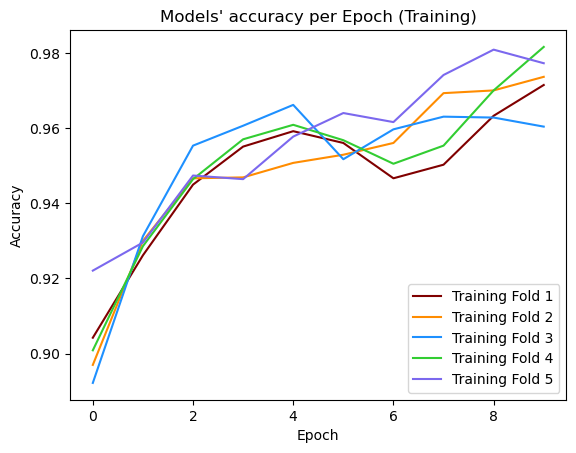

In [12]:
plt.title('Models\' accuracy per Epoch (Training)')
plt.plot(model_history_train[0]['accuracy'], label='Training Fold 1', color = 'maroon', linestyle = 'solid')
plt.plot(model_history_train[1]['accuracy'], label='Training Fold 2', color = 'darkorange', linestyle = 'solid')
plt.plot(model_history_train[2]['accuracy'], label='Training Fold 3', color = 'dodgerblue', linestyle = 'solid')
plt.plot(model_history_train[3]['accuracy'], label='Training Fold 4', color = 'limegreen', linestyle = 'solid')
plt.plot(model_history_train[4]['accuracy'], label='Training Fold 5', color = 'mediumslateblue', linestyle = 'solid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

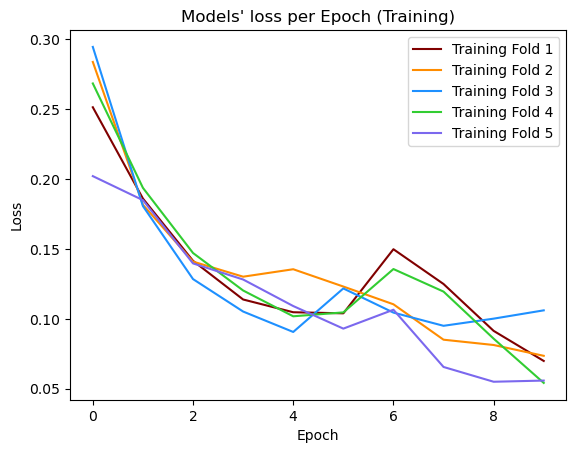

In [13]:
plt.title('Models\' loss per Epoch (Training)')
plt.plot(model_history_train[0]['loss'], label='Training Fold 1', color = 'maroon', linestyle = 'solid')
plt.plot(model_history_train[1]['loss'], label='Training Fold 2', color = 'darkorange', linestyle = 'solid')
plt.plot(model_history_train[2]['loss'], label='Training Fold 3', color = 'dodgerblue', linestyle = 'solid')
plt.plot(model_history_train[3]['loss'], label='Training Fold 4', color = 'limegreen', linestyle = 'solid')
plt.plot(model_history_train[4]['loss'], label='Training Fold 5', color = 'mediumslateblue', linestyle = 'solid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

---------- Model 1 ---------
Recall score: 0.6461232604373758
Precision score: 0.9502923976608187
F1-score : 0.7692307692307693

---------- Model 2 ---------
Recall score: 0.740530303030303
Precision score: 0.7947154471544715
F1-score : 0.7666666666666666

---------- Model 3 ---------
Recall score: 0.6699029126213593
Precision score: 0.9478021978021978
F1-score : 0.7849829351535836

---------- Model 4 ---------
Recall score: 0.722117202268431
Precision score: 0.9526184538653366
F1-score : 0.8215053763440859

---------- Model 5 ---------
Recall score: 0.8958333333333334
Precision score: 0.8857677902621723
F1-score : 0.8907721280602637



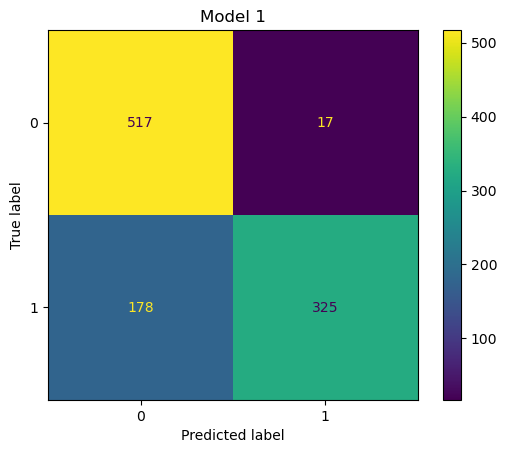

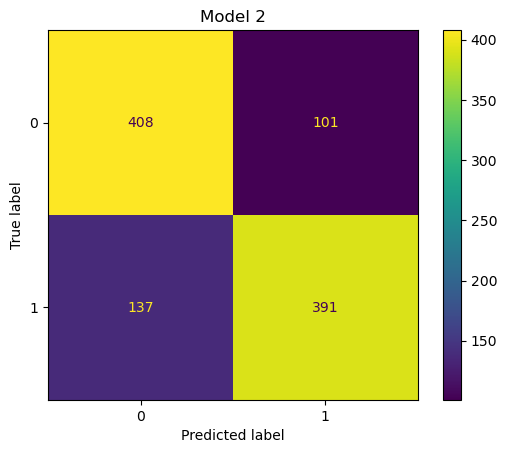

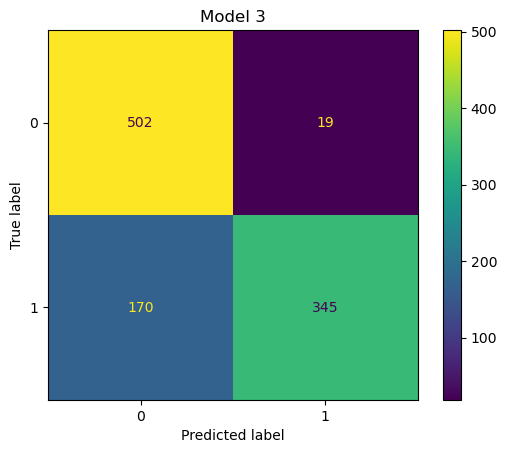

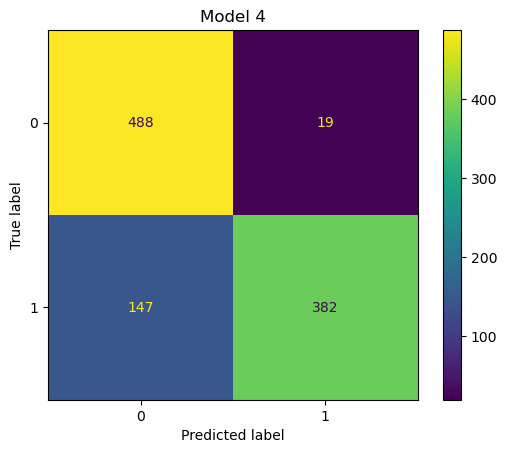

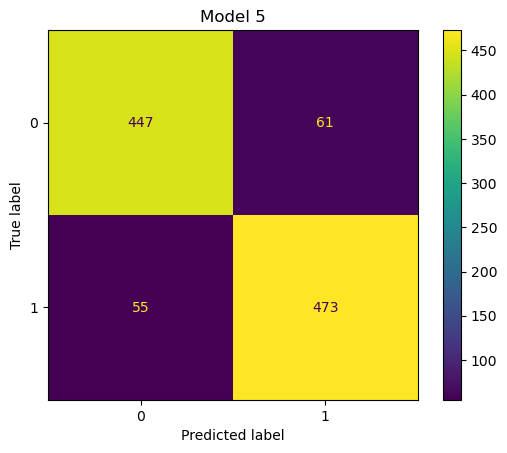

In [14]:
# Printing confusion matrices for the validation folds
i = 0
for pred in Y_pred_list:
    print(f"---------- Model {i + 1} ---------")
    print(f'Recall score: {recall_score(Y_val_list[i], pred)}')
    print(f'Precision score: {precision_score(Y_val_list[i], pred)}')
    print(f'F1-score : {f1_score(Y_val_list[i], pred)}')
    print("", end="\n")
    cm = confusion_matrix(Y_val_list[i], pred)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    disp.plot()
    plt.title(f"Model {i+1}")
    i += 1

In [15]:
# Printing zero-one loss and accuracy on the validations folds
i = 1
for stats in model_history_val:
    print(f"---------- Model {i} ---------")
    print(f"Zero-one loss: {stats['loss'][0]}")
    print(f"Accuracy: {stats['accuracy'][0]}")
    print("", end="\n\n")
    i += 1

---------- Model 1 ---------
Zero-one loss: 0.18804243008678878
Accuracy: 0.8119575699132112


---------- Model 2 ---------
Zero-one loss: 0.2295081967213115
Accuracy: 0.7704918032786885


---------- Model 3 ---------
Zero-one loss: 0.18243243243243246
Accuracy: 0.8175675675675675


---------- Model 4 ---------
Zero-one loss: 0.16023166023166024
Accuracy: 0.8397683397683398


---------- Model 5 ---------
Zero-one loss: 0.11196911196911197
Accuracy: 0.888030888030888




<h1>Explainability<h1>

In [16]:
i = 1
for n_per_model in n_chihuahua_muffin:
    print(f'Fold {i}')
    print(f'Percentage of chihuahua examples (train) {i + 1}: { round( ( n_per_model["train_chihuahua"] / ( n_per_model["train_chihuahua"] + n_per_model["train_muffin"] ) ) * 100 ) }')
    print(f'Percentage of muffin examples (train) {i + 1}: { round( ( n_per_model["train_muffin"] / ( n_per_model["train_chihuahua"] + n_per_model["train_muffin"] ) ) * 100 ) }')
    print(f'Percentage of chihuahua examples (validation) {i + 1}: { round( ( n_per_model["val_chihuahua"] / ( n_per_model["val_chihuahua"] + n_per_model["val_muffin"] ) ) * 100 ) }')
    print(f'Percentage of muffin examples (validation) {i + 1}: { round( ( n_per_model["val_muffin"] / ( n_per_model["val_chihuahua"] + n_per_model["val_muffin"] ) ) * 100 ) }')
    print("", end="\n")
    i += 1

Fold 1
Percentage of chihuahua examples (train) 2: 49
Percentage of muffin examples (train) 2: 51
Percentage of chihuahua examples (validation) 2: 51
Percentage of muffin examples (validation) 2: 49

Fold 2
Percentage of chihuahua examples (train) 3: 50
Percentage of muffin examples (train) 3: 50
Percentage of chihuahua examples (validation) 3: 49
Percentage of muffin examples (validation) 3: 51

Fold 3
Percentage of chihuahua examples (train) 4: 50
Percentage of muffin examples (train) 4: 50
Percentage of chihuahua examples (validation) 4: 50
Percentage of muffin examples (validation) 4: 50

Fold 4
Percentage of chihuahua examples (train) 5: 50
Percentage of muffin examples (train) 5: 50
Percentage of chihuahua examples (validation) 5: 49
Percentage of muffin examples (validation) 5: 51

Fold 5
Percentage of chihuahua examples (train) 6: 50
Percentage of muffin examples (train) 6: 50
Percentage of chihuahua examples (validation) 6: 49
Percentage of muffin examples (validation) 6: 51



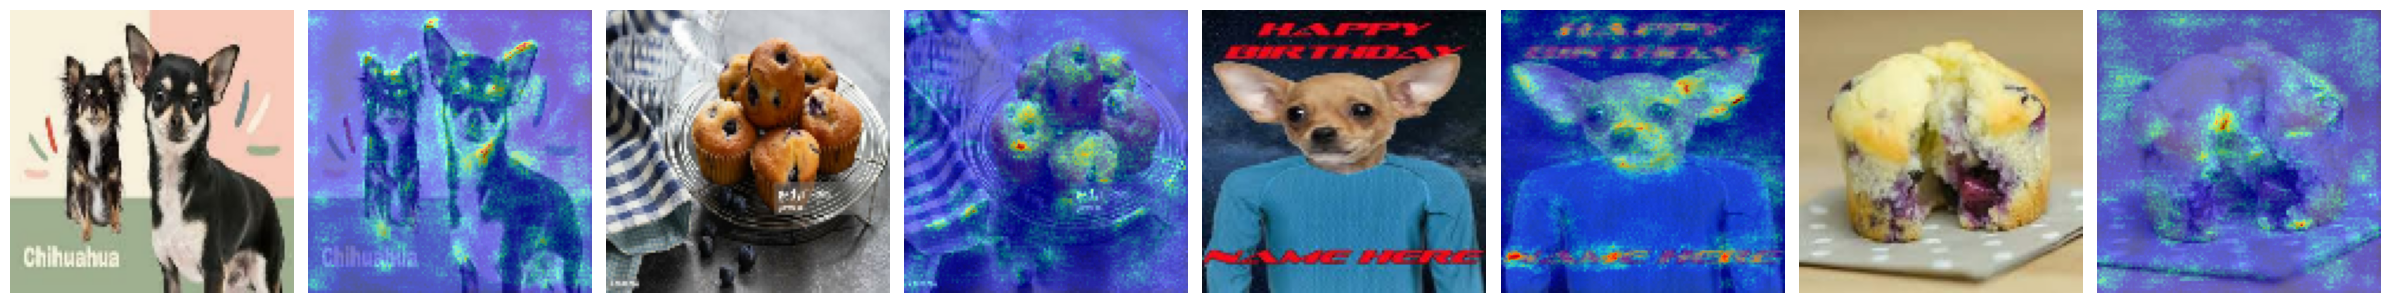

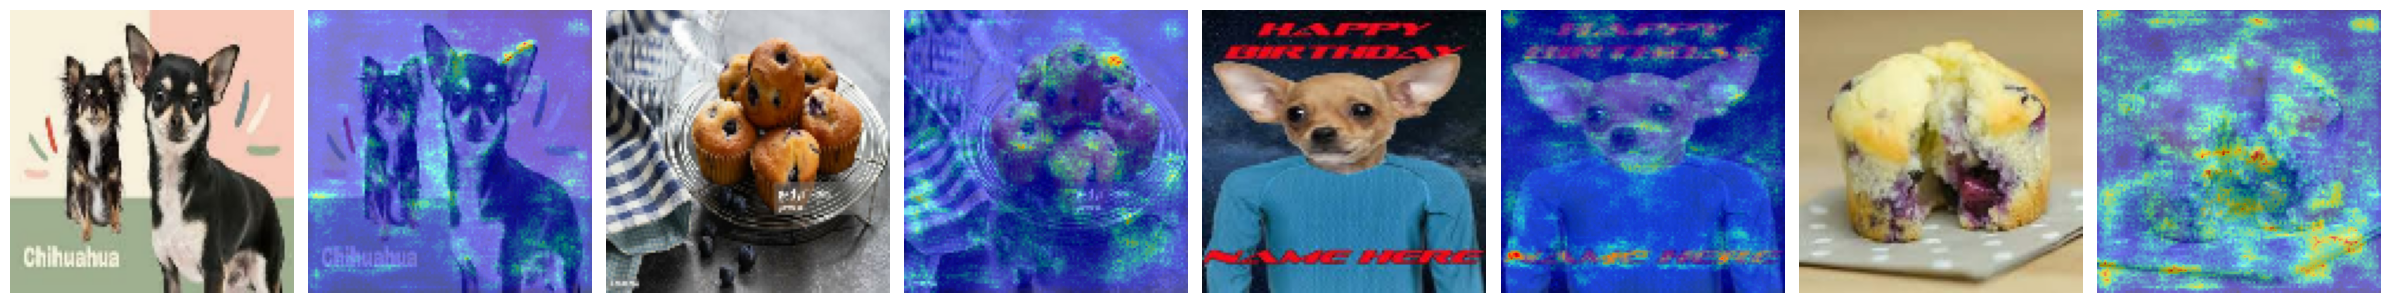

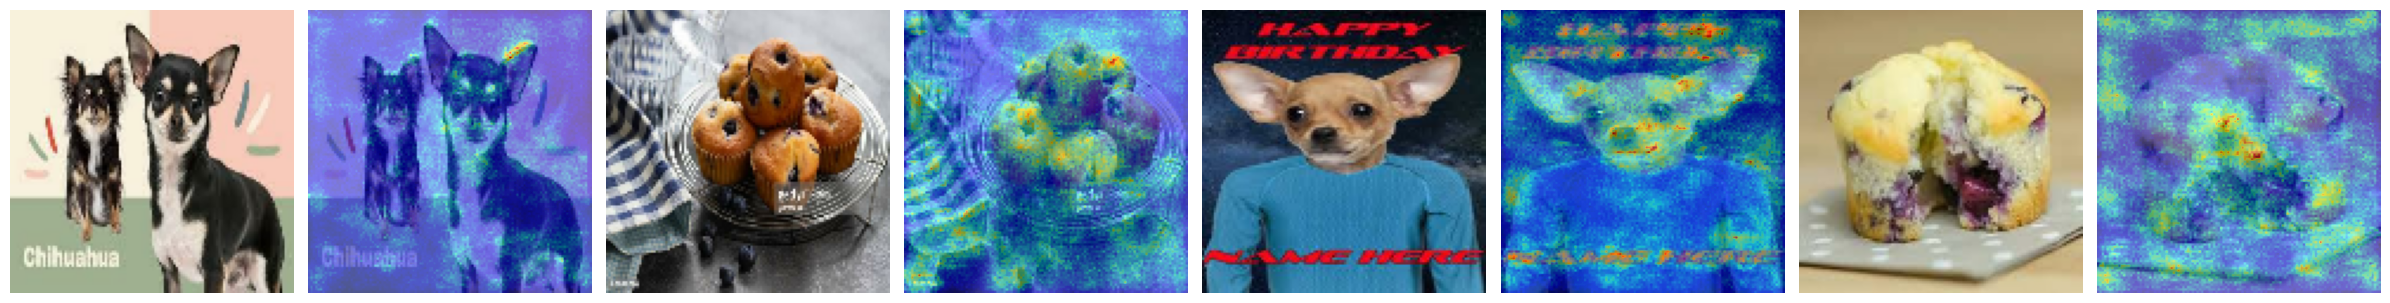

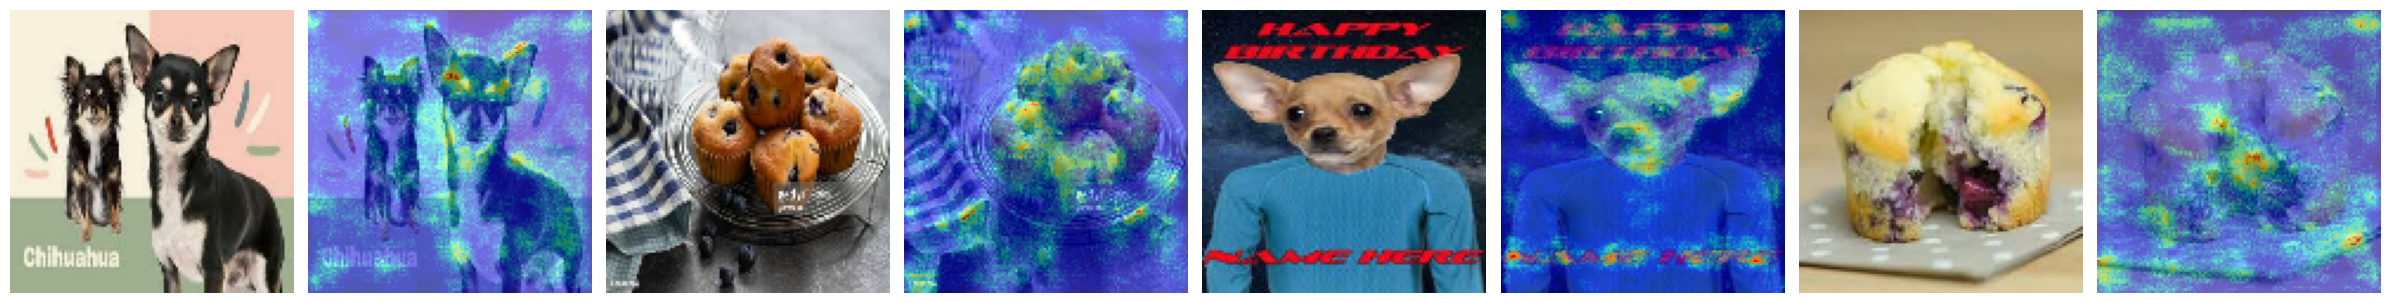

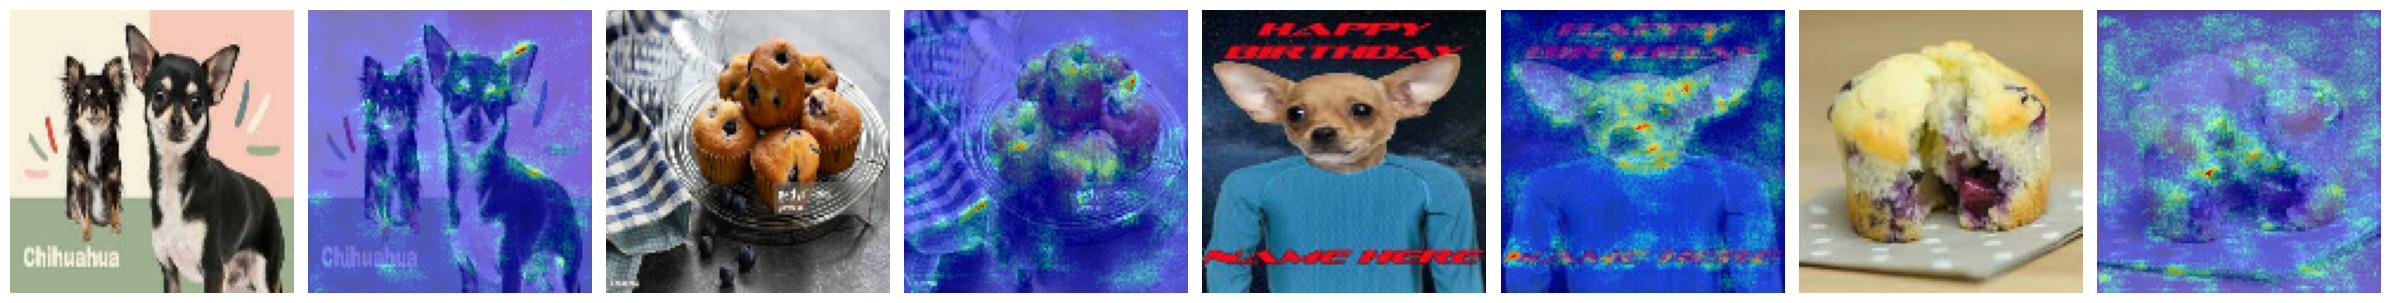

In [17]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.saliency import Saliency

# In the for loop, each one of the 5-cross validation model is retrieved. As they're only used for prediction by the function 'Saliency' and
# they're not used for training, there are some unused values, in particular the one about the optimizer (learning rate, beta_1, beta_2). Those
# cause tensorflow to raise unnecessary warnings in this context, therefore tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# is use to turn off tensorflow log messages to avoid the unnecessary warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

replace2linear = ReplaceToLinear()

i = 0
for i in range(5):
    
    model = tuner.get_best_models()[0]
    model.load_weights(f"custom/bst_mdl_{i + 1}/cp.ckpt")

    saliency = Saliency(model,
                        model_modifier = replace2linear,
                        clone = True)

    score = BinaryScore([Y[2050], Y[2051], Y[2052], Y[2053]])
    img = X[2050:2054]
    saliency_map = saliency(score, img, smooth_samples = 20, smooth_noise = 0.2)

    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(24, 8))
    for i in range(4):
        ax[i * 2].imshow(img[i].astype("uint8"))
        ax[i * 2 + 1].imshow(img[i].astype("uint8"))
        ax[i * 2 + 1].imshow(saliency_map[i], cmap='jet', alpha=0.5)
        ax[i * 2].axis('off')
        ax[i * 2 + 1].axis('off')
    plt.tight_layout()
    plt.show()